<a href="https://colab.research.google.com/github/Rohini0106-ui/Bioinformatics-/blob/main/AI_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Requirements:
# pip install numpy pandas scikit-learn xgboost shap matplotlib seaborn

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Synthetic dataset generator (binary disease risk)
def make_synthetic_health_data(n=5000, seed=42):
    np.random.seed(seed)
    age = np.random.normal(60, 12, n).clip(18, 90)
    bmi = np.random.normal(28, 6, n).clip(15, 50)
    blood_glucose = np.random.normal(110, 30, n).clip(60, 400)
    hba1c = 5 + (blood_glucose - 90)/50 + np.random.normal(0, 0.3, n)
    gene1 = np.random.binomial(1, 0.2, n)  # example risk allele
    gene2 = np.random.binomial(1, 0.1, n)
    smoking = np.random.choice([0,1], size=n, p=[0.7,0.3])
    hypertension = np.random.choice([0,1], size=n, p=[0.6,0.4])
    # Linear risk score + interactions:
    risk_score = (
        0.03*(age-50) + 0.06*(bmi-25) + 0.02*(blood_glucose-100)
        + 0.8*gene1 + 0.4*gene2 + 0.5*smoking + 0.7*hypertension
        + 0.15*(gene1*smoking)
        + np.random.normal(0,1,n)
    )
    # probability via logistic
    p = 1 / (1 + np.exp(-risk_score))
    disease = (np.random.rand(n) < p).astype(int)
    df = pd.DataFrame({
        'age': age, 'bmi': bmi, 'blood_glucose': blood_glucose, 'hba1c': hba1c,
        'gene1': gene1, 'gene2': gene2, 'smoking': smoking, 'hypertension': hypertension,
        'disease': disease
    })
    return df

df = make_synthetic_health_data(n=3000)
X = df.drop(columns='disease')
y = df['disease']

# 2) Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3) Train XGBoost classifier
model = xgb.XGBClassifier(n_estimators=200, max_depth=4, learning_rate=0.05, use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# 4) Evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

# 5) SHAP explanations
explainer = shap.Explainer(model, X_train)   # model-agnostic TreeExplainer inside
shap_values = explainer(X_test)

# 6) Summary plot (global importance)
shap.summary_plot(shap_values, X_test, show=False)
plt.savefig("shap_summary_plot.png", bbox_inches='tight', dpi=150)
plt.close()

# 7) Dependence plot for top feature
# find top feature by mean(|SHAP|)
import numpy as np
feature_importance = np.abs(shap_values.values).mean(axis=0)
top_idx = np.argmax(feature_importance)
top_feature = X_test.columns[top_idx]
print("Top feature:", top_feature)
shap.dependence_plot(top_feature, shap_values.values, X_test, show=False)
plt.savefig("shap_dependence_{}.png".format(top_feature), bbox_inches='tight', dpi=150)
plt.close()

# 8) Force plot for a single patient (local explanation)
i = 5  # index within X_test
# For saving force plot as PNG: use shap.plots._waterfall.waterfall_legacy or matplotlib wrapper
shap.plots.force(shap_values[i], matplotlib=True, show=False)
plt.savefig("shap_force_patient_{}.png".format(i), bbox_inches='tight', dpi=150)
plt.close()

print("Saved: shap_summary_plot.png, shap_dependence_{}.png, shap_force_patient_{}.png".format(top_feature, i))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:36:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.7366666666666667
AUC: 0.6761101205935618
              precision    recall  f1-score   support

           0       0.54      0.23      0.32       163
           1       0.76      0.93      0.84       437

    accuracy                           0.74       600
   macro avg       0.65      0.58      0.58       600
weighted avg       0.70      0.74      0.70       600



/tmp/ipython-input-3494004571.py:64: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, show=False)


Top feature: blood_glucose
Saved: shap_summary_plot.png, shap_dependence_blood_glucose.png, shap_force_patient_5.png


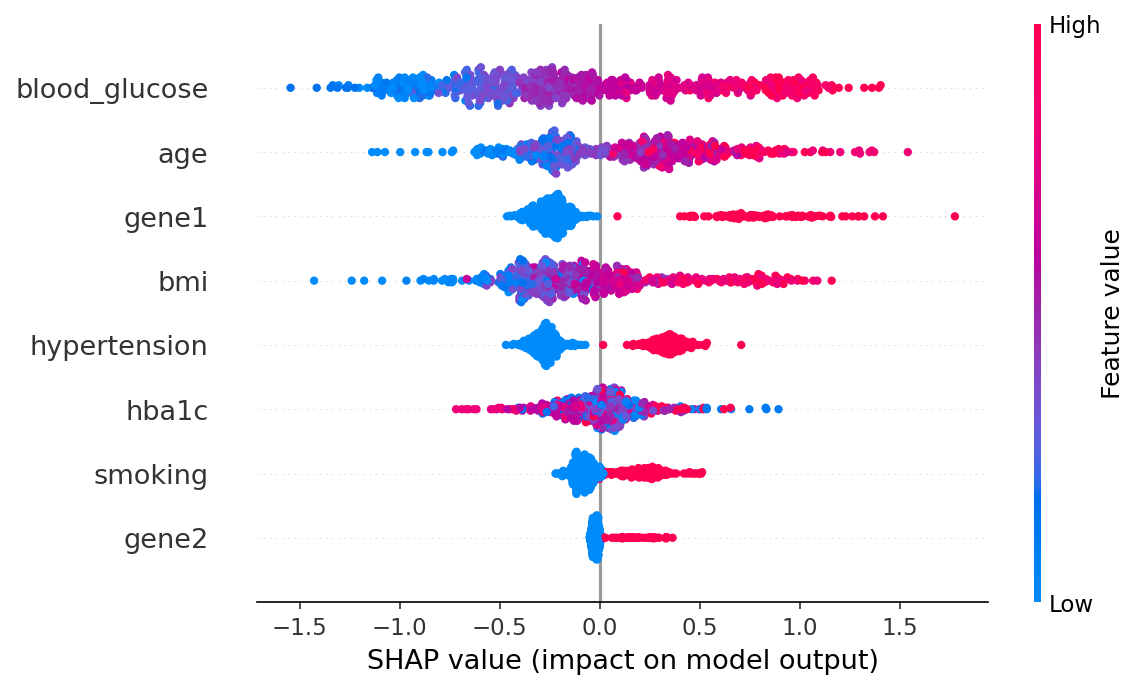

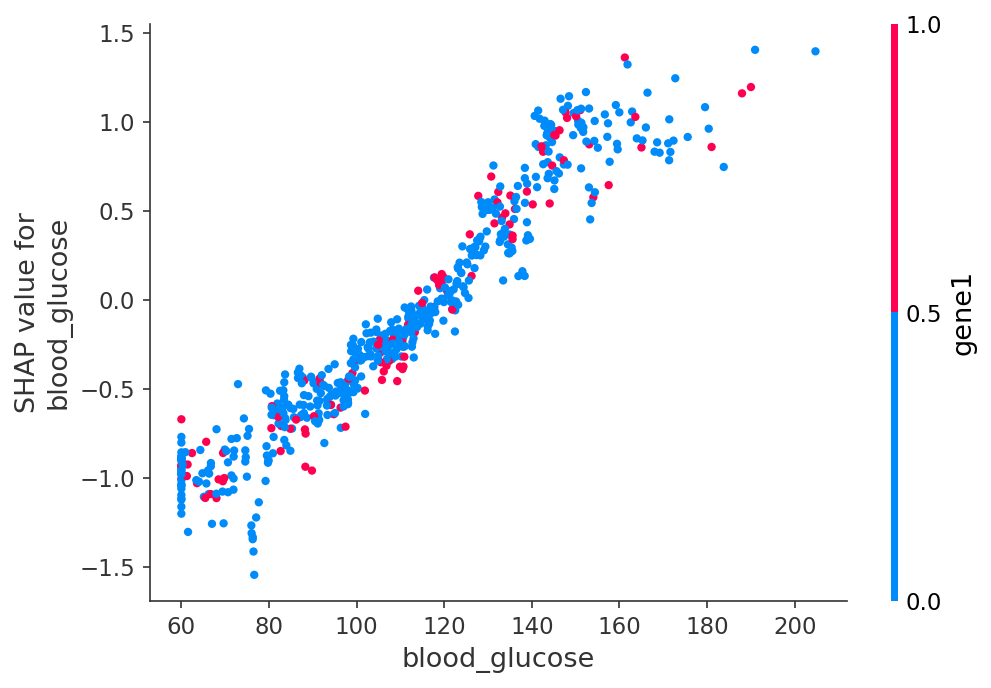

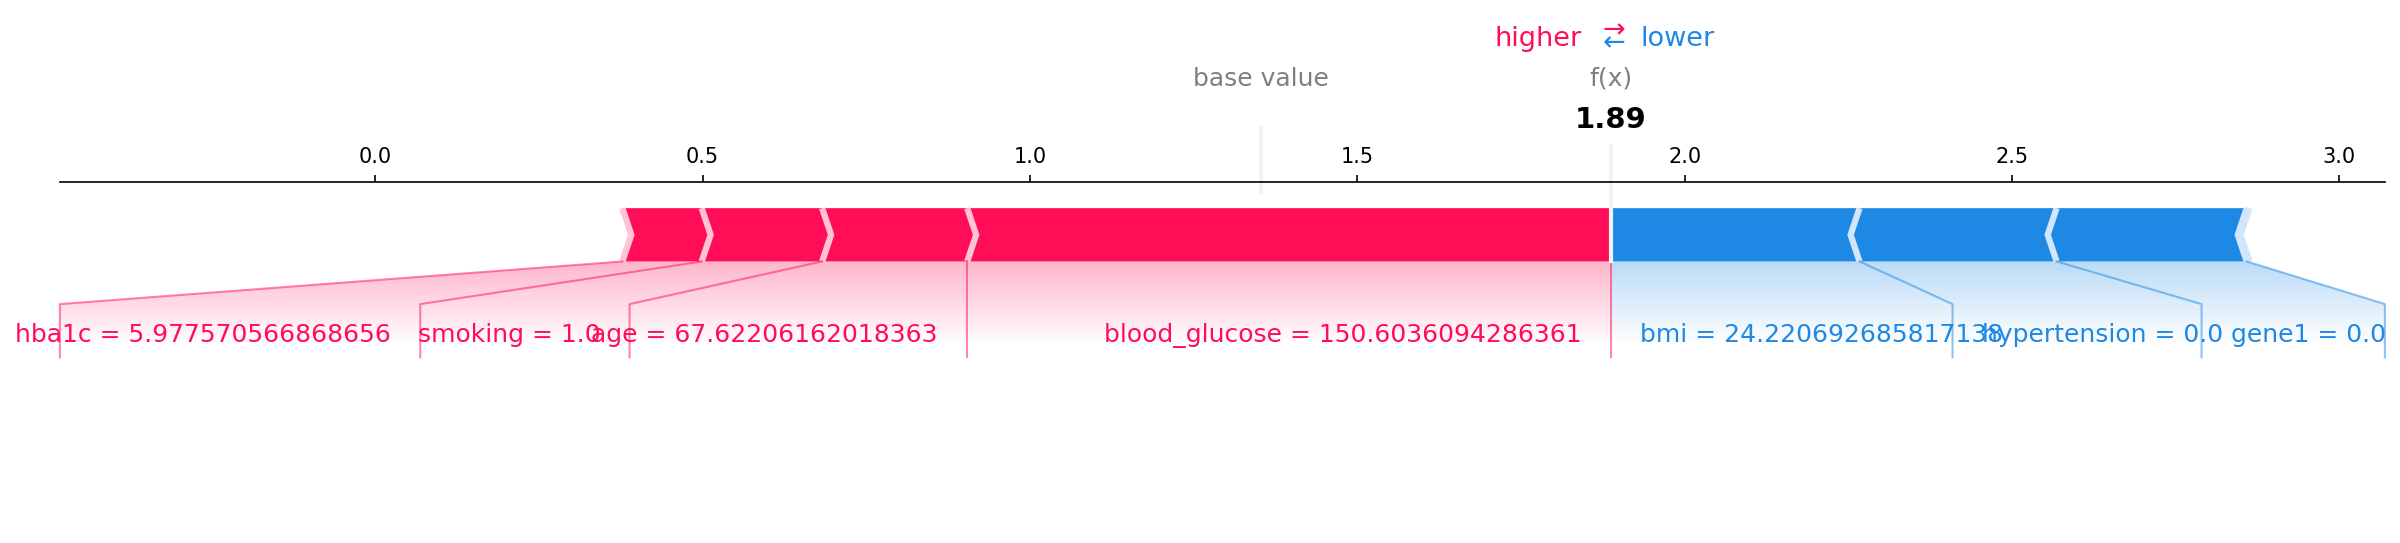

In [ ]:
from IPython.display import Image, display

display(Image(filename="shap_summary_plot.png", width=600))
display(Image(filename="shap_dependence_blood_glucose.png", width=600))
display(Image(filename="shap_force_patient_5.png", width=600))
